In [1]:
#Import packages
#import numpy as np
import snowflake.connector
import pandas as pd
import spacy
from sklearn.preprocessing import OneHotEncoder


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3,application_1600955176122_0004,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
#Snowflake connection info
sfOptions = {
  'sfURL' : 'powerreviews.snowflakecomputing.com',
  'sfAccount' : 'powerreviews',
  'sfUser' : 'APP_SPARK_PROD',
  'sfPassword' : '>6txhcQ*7&^Qrq`j',
  'sfDatabase' : 'ANALYTICS_PROD',
  'sfSchema' : 'ANALYTICS',
  'sfWarehouse' : 'LOWER_ENV_WAREHOUSE'
}
SNOWFLAKE_SOURCE_NAME = "net.snowflake.spark.snowflake"


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
query_old = "select * \
from \
(select ugc_id as mod_ugc_id, created_date as mod_date, year(created_date)*100+month(created_date) as YYYYMM \
from cdm.observation as o \
where observation_type_code = 'PM' and observation_client_id =1 and ugc_type = 'review') as moderated_reviews \
left join \
(select ugc_id, observation_type_code \
from cdm.observation as o \
where observation_type_code in ('NR','PII','PR','CS','DC','CR','FRD','TST','CC','EWL','SC','PIM','LC','WEB','FL','SA','URL','CV','US') \
 and observation_client_id =1 and ugc_type = 'review') as observation_reviews \
on moderated_reviews.mod_ugc_id = observation_reviews.ugc_id \
left join \
(select ugc_id as r_ugc_id, review_headline, review_comments, review_rating, reviewer_nickname, locale \
from analytics.review ) as r \
on r.r_ugc_id = moderated_reviews.mod_ugc_id \
where locale in ('en_US','en_GB','en_CA') \
and mod_date > '2020-09-21'   "



VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
query = "select distinct r.ugc_id, r.created_date, r.review_headline, \
r.review_comments, r.review_rating, r.reviewer_nickname, r.locale, r.observations \
from analytics.review as r \
left join cdm.observation as o \
on r.ugc_id = o.ugc_id \
where contains(r.observations, 'PM') \
and r.locale in ('en_US','en_GB','en_CA') \
and o.created_date > '2020-09-01'   "

In [ ]:
#Use review data set to get observation codes bc they are already comma separated and less joins to perform
#Still need observation set though to get observation created date
#This is bc review could be from ages ago but we could have imported recently and moderated it
#Want to make sure we include as many observation labels as possible for most accurate model



In [4]:
#Spark data frame

reviews = spark.read.format(SNOWFLAKE_SOURCE_NAME) \
          .options(**sfOptions).option("query", query).load()
reviews.show(5)
reviews.count()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+------+---------+---------------------+---------+---------------+--------------------+-------------+-----------------+------+
|MOD_UGC_ID|            MOD_DATE|YYYYMM|   UGC_ID|OBSERVATION_TYPE_CODE| R_UGC_ID|REVIEW_HEADLINE|     REVIEW_COMMENTS|REVIEW_RATING|REVIEWER_NICKNAME|LOCALE|
+----------+--------------------+------+---------+---------------------+---------+---------------+--------------------+-------------+-----------------+------+
| 298822510|2020-09-23 12:15:...|202009|298822510|                   NR|298822510|            yes|                 Xxx|            4|          Maureen| en_US|
| 298822508|2020-09-23 12:16:...|202009|298822508|                   NR|298822508|            Yes|                 Xxx|            4|          Maureen| en_US|
| 300308297|2020-09-21 13:53:...|202009|300308297|                   PR|300308297|       Hartford|I ain't get nun b...|            2|            James| en_US|
| 300311401|2020-09-21 13:54:...|202009|300311

In [5]:
counts=reviews.groupBy('OBSERVATION_TYPE_CODE').count().orderBy('count', ascending = False)
counts.show(25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+--------+
|OBSERVATION_TYPE_CODE|   count|
+---------------------+--------+
|                   SC|   62783|
|                   CC|   53152|
|                  PIM|   41224|
|                  EWL|   34519|
|                  FRD|   31014|
|                   LC|   23979|
|                  TST|   19923|
|                   PR|   93587|
|                   CR|   80136|
|                   CV|     835|
|                   US|     304|
|                 null|63879110|
|                   NR|  420905|
|                  PII|  306726|
|                   SA|   11593|
|                  URL|   11377|
|                   DC|    9102|
|                  WEB|   30624|
|                   FL|   29200|
|                   CS|   24925|
+---------------------+--------+

In [6]:
#Absolutely will not sort for a Spark dataframe, convert to Pandas and sort
counts_pd = counts.select("*").toPandas()
counts_pd.sort_values(by='count', ascending = False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   OBSERVATION_TYPE_CODE     count
2                   None  63879110
3                     NR    420905
4                    PII    306726
7                     PR     93587
8                     CR     80136
9                     SC     62783
10                    CC     53152
11                   PIM     41224
0                    EWL     34519
1                    FRD     31014
17                   WEB     30624
18                    FL     29200
19                    CS     24925
12                    LC     23979
13                   TST     19923
14                    SA     11593
15                   URL     11377
16                    DC      9102
5                     CV       835
6                     US       304

In [7]:
#Clear plot memory
#plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

name 'plt' is not defined
Traceback (most recent call last):
NameError: name 'plt' is not defined



In [8]:
%matplotlib inline

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
counts_sorted = counts_pd.nlargest(columns="count", n = 50) 
ax = sns.barplot(data=counts_sorted, x= "count", y = "OBSERVATION_TYPE_CODE", color="b") 
#ax2 = sns.barplot(data=counts_sorted.fillna('NULL'), x= "count", y = "OBSERVATION_TYPE_CODE") 
ax.set(ylabel = 'Count') 
plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

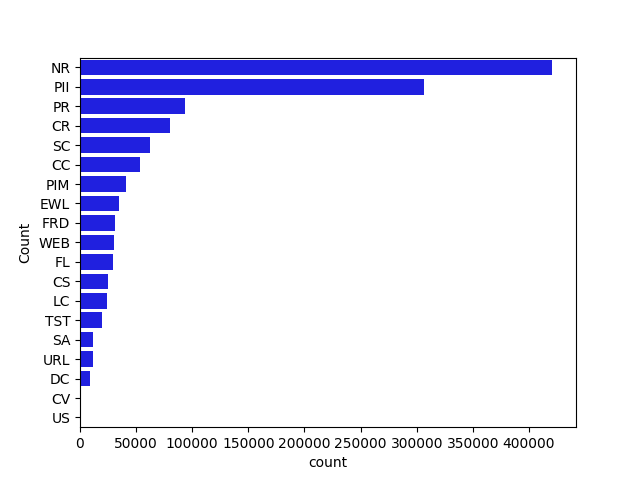

In [10]:
%matplot plt

In [25]:
mo_counts=reviews.groupBy('OBSERVATION_TYPE_CODE','YYYYMM').count().orderBy('count', ascending = False)
mo_counts.show(25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+------+-----+
|OBSERVATION_TYPE_CODE|YYYYMM|count|
+---------------------+------+-----+
|                   DC|202003|  105|
|                   SA|201810|   98|
|                   DC|201909|   92|
|                   DC|202008|   92|
|                   SA|201811|   87|
|                   DC|202002|   85|
|                   DC|201910|   81|
|                   SA|201809|   80|
|                   DC|202007|   80|
|                   CV|202001|   53|
|                   CV|201910|   50|
|                   CV|201906|   50|
|                   CV|201909|   49|
|                   CV|202007|   46|
|                   CV|202009|   44|
|                   CV|201911|   39|
|                   CV|202002|   38|
|                   CV|201903|   37|
|                   CV|201811|   36|
|                   CV|202008|   36|
|                   CV|202004|   34|
|                   CV|201809|   34|
|                   CV|202005|   34|
|                   CV|201908|   32|
|

In [26]:
mo_counts_pd = mo_counts.select("*").toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
mo_counts_nr = mo_counts_pd[mo_counts_pd['OBSERVATION_TYPE_CODE']=='NR']
mo_counts_nr.head(25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

    OBSERVATION_TYPE_CODE  YYYYMM  count
61                     NR  201906  11548
62                     NR  201908  11540
63                     NR  201907  11324
65                     NR  201909  10328
330                    NR  201901  33655
332                    NR  202005  31240
334                    NR  202007  25156
335                    NR  202006  24980
336                    NR  201912  22908
337                    NR  202008  20553
338                    NR  201812  19799
339                    NR  202001  19749
340                    NR  201903  18053
341                    NR  202004  16685
342                    NR  202009  15846
345                    NR  201810  13591
346                    NR  201911  13429
348                    NR  201809  13217
351                    NR  201811  13128
352                    NR  201902  13067
354                    NR  202002  12459
356                    NR  201905  12244
357                    NR  201904  12214
359             

In [28]:
mo_counts_nr['YYYYMM'] = mo_counts_nr.YYYYMM.astype(int)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<string>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [29]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
counts_nr_sorted = mo_counts_nr.nlargest(columns="YYYYMM", n = 50) 
ax = sns.barplot(data=counts_nr_sorted, x= "YYYYMM", y = "count", color="b") 
plt.xticks(rotation=90)
plt.show()
#sns.lineplot(x="YYYYMM", y="count", data=mo_counts_nr)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

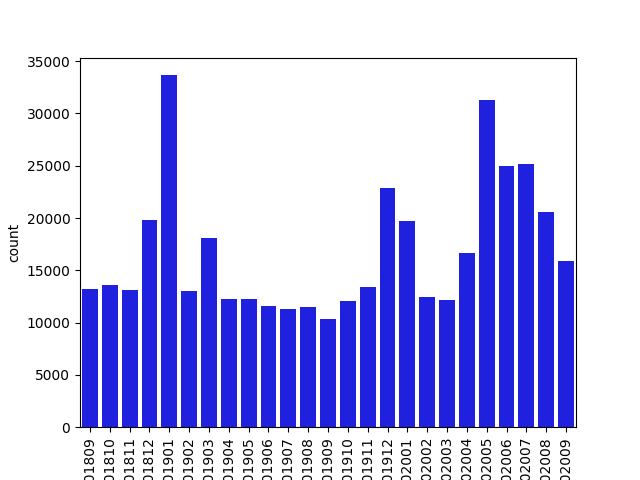

In [31]:
%matplot plt

In [18]:
rating=reviews.groupBy('OBSERVATION_TYPE_CODE').mean('REVIEW_RATING').withColumnRenamed('avg(REVIEW_RATING)','AVG_RATING')
rating.show(25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+----------+
|OBSERVATION_TYPE_CODE|AVG_RATING|
+---------------------+----------+
|                  URL|  3.321702|
|                   US|  4.148026|
|                   SA|  2.538515|
|                   CV|  4.491018|
|                  FRD|  4.576546|
|                   CR|  3.507500|
|                   CS|  2.305436|
|                  EWL|  3.640893|
|                  PII|  4.312934|
|                   NR|  2.561687|
|                   FL|  4.077466|
|                  TST|  4.271495|
|                  PIM|  3.036944|
|                   CC|  2.904481|
|                   PR|  2.939970|
|                   LC|  1.429668|
|                 null|  4.410663|
|                   SC|  1.883424|
|                  WEB|  2.082060|
|                   DC|  4.129532|
+---------------------+----------+

In [19]:
rating_pd = rating.select("*").toPandas()
rating_pd.sort_values(by='AVG_RATING', ascending = False)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   OBSERVATION_TYPE_CODE AVG_RATING
7                    FRD     4.5765
1                     CV     4.4910
15                  None     4.4107
9                    PII     4.3129
4                    TST     4.2715
12                    US     4.1480
19                    DC     4.1295
16                    FL     4.0775
8                    EWL     3.6409
6                     CR     3.5075
11                   URL     3.3217
2                    PIM     3.0369
13                    PR     2.9400
3                     CC     2.9045
10                    NR     2.5617
0                     SA     2.5385
5                     CS     2.3054
17                   WEB     2.0821
18                    SC     1.8834
14                    LC     1.4297

In [20]:
rating_pd['AVG_RATING'] = rating_pd.AVG_RATING.astype(float)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
rating_pd.head()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  OBSERVATION_TYPE_CODE  AVG_RATING
0                    SA      2.5385
1                    CV      4.4910
2                   PIM      3.0369
3                    CC      2.9045
4                   TST      4.2715

In [22]:
plt.clf()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
rating_sorted = rating_pd.nlargest(columns="AVG_RATING", n = 50) 
ax = sns.barplot(data=rating_sorted, x= "AVG_RATING", y = "OBSERVATION_TYPE_CODE", color="b") 
#plt.xticks(rotation=90)
plt.show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

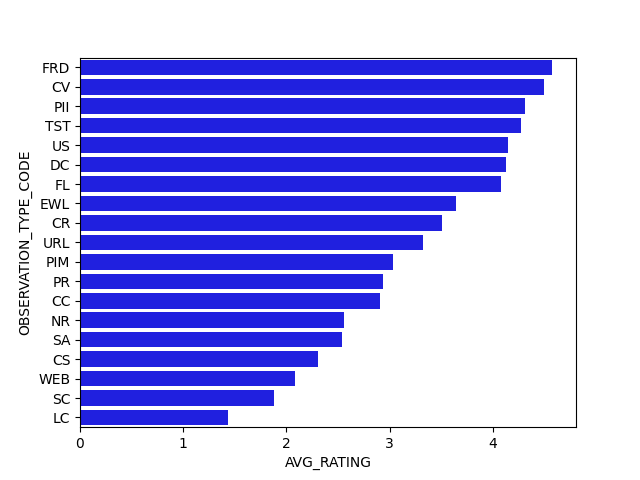

In [24]:
%matplot plt